In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler, DataLoader
from tqdm import tqdm
from PIL import Image

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [4]:
#Creating custom dataset
data_path_train = "C:/Users/M/Desktop/Python/Amber/Data/Train3"
data_path_test = "C:/Users/M/Desktop/Python/Amber/Data/Test3"
IMG_SIZE = 224

transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5)),
        ]
    )

class CustomDataSet():
       
    def __init__(self,data_path,transform=None):
        
        self.transform = transform
        
        self.data_path = data_path
        self.data = dset.ImageFolder(self.data_path)
        self.nrofclass = len(self.data.classes)
                
        self.custom_data = []
        for i in tqdm(range(len(self.data))):
            ImgPath = self.data.samples[i][0]
            img = cv2.imread(ImgPath)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # gray scale for shape 
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            Category = self.data.samples[i][1]
            #y_label = torch.tensor(np.eye(self.nrofclass)[Category]) # one hot encoding
            y_label = torch.tensor(Category)
            self.custom_data.append([img, y_label]) 
            
    def __len__(self):
        return len(self.custom_data)
    
    def __getitem__(self, idx):
        img, class_id = self.custom_data[idx]
        if self.transform is not None:
            img = self.transform(img)
        return (img, class_id)

DataSetTrain = CustomDataSet(data_path_train,transform=transform)
DataSetTest = CustomDataSet(data_path_test,transform=transform)

100%|████████████████████████████████████████████████████████████████████████████| 1102/1102 [00:00<00:00, 2682.06it/s]


In [ ]:
DataSetTrain[500][1]

In [5]:
valid_size = int(0.2 * len(DataSetTest))
test_size = len(DataSetTest) - valid_size
valid_dataset, test_dataset = torch.utils.data.random_split(DataSetTest, [valid_size, test_size])

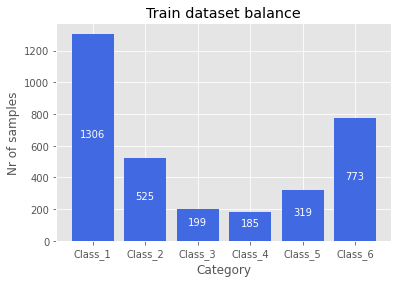

In [6]:
# Checking for class balance
DataSummary = []
class_weights = []
for i in range(len(DataSetTrain.data.classes)):
    count = DataSetTrain.data.targets.count(i)
    DataSummary.append(count)
    
DataBalance = dict(zip(DataSetTrain.data.classes,DataSummary))

Categories = list(DataBalance.keys())
Samples = list(DataBalance.values())

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center', color = 'white')

plt.style.use('ggplot')
plt.title('Train dataset balance')
plt.xlabel('Category')
plt.ylabel('Nr of samples')
plt.bar(Categories,Samples, color = 'royalblue')
addlabels(Categories,Samples)
plt.show()

In [7]:
# Initialise class weights
class_weights = []
for i in range(len(DataSetTrain.data.classes)):
    count = DataSetTrain.data.targets.count(i)
    class_weights.append(1/(count))

sample_weights = [0] * len(DataSetTrain)

for idx, (data, label) in enumerate(DataSetTrain):
        class_weight = class_weights[label.argmax()]
        sample_weights[idx] = class_weight

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [36]:
#Data loaders
BATCH_SIZE = 50
train_data_loader = DataLoader(DataSetTrain, 
                               batch_size=BATCH_SIZE,  
                               #shuffle=True
                               sampler=sampler
                               )

valid_data_loader = DataLoader(valid_dataset, 
                              batch_size=20,  
                             # num_workers=0,
                              shuffle=True
                              )

test_data_loader = DataLoader(test_dataset, 
                              batch_size=20,  
                             # num_workers=0,
                              shuffle=False
                              )

In [9]:
from torchvision.utils import _log_api_usage_once
import torch.nn.init as init

class Fire(nn.Module):
    def __init__(self, inplanes: int, squeeze_planes: int, expand1x1_planes: int, expand3x3_planes: int) -> None:
        super().__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes, kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes, kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat(
            [self.expand1x1_activation(self.expand1x1(x)), self.expand3x3_activation(self.expand3x3(x))], 1
        )


class SqueezeNet(nn.Module):
    def __init__(self, num_classes: int = 6, dropout: float = 0.5) -> None:
        super().__init__()
        _log_api_usage_once(self)
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(64, 16, 64, 64),
            Fire(128, 16, 64, 64),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(128, 32, 128, 128),
            Fire(256, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(256, 48, 192, 192),
            Fire(384, 48, 192, 192),
            Fire(384, 64, 256, 256),
            Fire(512, 64, 256, 256),
            )

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout), final_conv, nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)

In [37]:
net = SqueezeNet()
net.to(device)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [38]:
EPOCHS = 10
optimizer = optim.Adam(net.parameters(), lr=1e-3)
loss_function = nn.CrossEntropyLoss()
steps = len(train_data_loader)
stepsv = len(test_data_loader)
val_losses = []
train_losses = []
val_accs = []
train_accs = []
for epoch in range(EPOCHS):
    total = 0
    train_acc = 0
    train_loss = 0
    net.train()
    for step in tqdm(range(steps)):
        x, y = next(iter(train_data_loader))
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        outputs = net(x)
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step() 
        
        total += y.size(0)
        
        _, predicted = outputs.max(1)
  
        train_acc += (predicted == y).sum().cpu().detach().numpy()
        train_loss += loss.item()
        
    acct=100.*train_acc/total
    train_accs.append(acct)
    losst= train_loss/len(train_data_loader)
    train_losses.append(losst)
    
    totalv = 0
    val_acc = 0
    val_loss = 0
    net.eval()
    with torch.no_grad():
        for step in tqdm(range(stepsv)):
            vinputs, vlabels = next(iter(valid_data_loader))
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            voutputs = net(vinputs)
            
            vloss = loss_function(voutputs, vlabels)
            
            totalv += vlabels.size(0)
        
            _, predictedv = voutputs.max(1)
            
            val_acc += (predictedv == vlabels).sum().cpu().detach().numpy()
            val_loss += vloss.item()
            
    accuv=100.*val_acc/totalv
    val_accs.append(accuv)
    lossv= val_loss/len(valid_data_loader)
    val_losses.append(lossv)
    
    print(f"Epoch: {epoch}. Loss: {losst}. Validation Loss: {lossv}")
    print(f"Train accuracy: {acct}. Validation accuracy: {accuv}")

  0%|                                                                                           | 0/67 [00:00<?, ?it/s]C:\Users\M\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 49.19it/s]


Epoch: 0. Loss: 1.5727890053791787. Validation Loss: 3.3623262082829193
Train accuracy: 38.656716417910445. Validation accuracy: 42.56410256410256


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 49.00it/s]


Epoch: 1. Loss: 1.5098137019285516. Validation Loss: 3.330813583205728
Train accuracy: 38.26865671641791. Validation accuracy: 49.23076923076923


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 49.37it/s]


Epoch: 2. Loss: 1.4321984337336982. Validation Loss: 3.0388419698266422
Train accuracy: 43.64179104477612. Validation accuracy: 50.0


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 49.56it/s]


Epoch: 3. Loss: 1.40365976895859. Validation Loss: 3.1701667939915374
Train accuracy: 44.507462686567166. Validation accuracy: 37.82051282051282


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 49.37it/s]


Epoch: 4. Loss: 1.2770438656878116. Validation Loss: 3.0131435429348663
Train accuracy: 49.701492537313435. Validation accuracy: 48.205128205128204


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 49.13it/s]


Epoch: 5. Loss: 1.2651846017410506. Validation Loss: 3.121488844647127
Train accuracy: 50.26865671641791. Validation accuracy: 46.02564102564103


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 49.19it/s]


Epoch: 6. Loss: 1.1447022521673744. Validation Loss: 2.7613273438285377
Train accuracy: 56.656716417910445. Validation accuracy: 55.64102564102564


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 49.69it/s]


Epoch: 7. Loss: 1.0227471305363214. Validation Loss: 2.592695281786077
Train accuracy: 62.83582089552239. Validation accuracy: 57.30769230769231


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 49.75it/s]


Epoch: 8. Loss: 0.9748974593717661. Validation Loss: 2.5684417135575237
Train accuracy: 65.16417910447761. Validation accuracy: 53.97435897435897


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 48.94it/s]

Epoch: 9. Loss: 0.8984009427810783. Validation Loss: 2.3059917653308197
Train accuracy: 67.19402985074628. Validation accuracy: 65.0


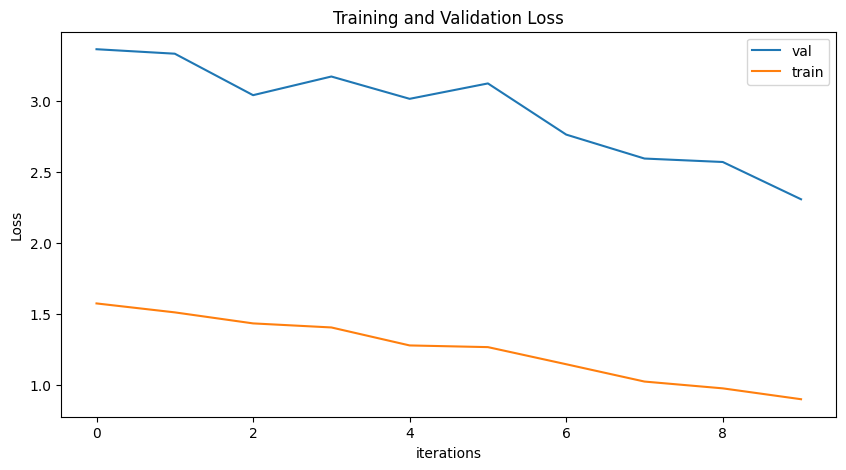

In [68]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

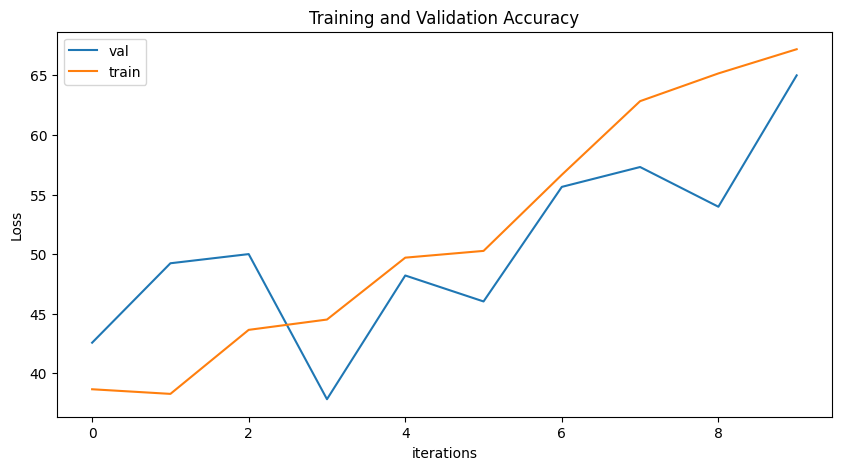

In [69]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_accs,label="val")
plt.plot(train_accs,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

# iterate over test data
y_pred = []
y_true = []
correct = 0
net.eval()
net.cpu()
total = 0
with torch.no_grad():
    for inputs, labels in test_data_loader:
           
            output = net(inputs) # Feed Network
            
            pred = output.max(1).indices.to(device)
            
            true = labels.to(device)
            
            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction
            
            labels = labels.cpu().numpy()
            y_true.extend(labels) # Save Truth
            
            total += true.size(0)
            correct += torch.sum(pred == true)
# constant for classes
Classes = ('1', '3', '3', '4', '5','6')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

print("Accuracy: ", (correct/total).item())

Accuracy:  0.6619170904159546


In [65]:
cf_matrix

array([[276,   6,   0,   0,  13,   9],
       [ 30,  81,   0,   0,   8,   0],
       [  5,   7,   0,   0,  34,   1],
       [  7,   2,   0,   0,  14,  17],
       [  2,   0,   0,   0,  69,   4],
       [ 37,  10,   0,   0,  55,  85]], dtype=int64)

Confusion matrix, without normalization
[[276   6   0   0  13   9]
 [ 30  81   0   0   8   0]
 [  5   7   0   0  34   1]
 [  7   2   0   0  14  17]
 [  2   0   0   0  69   4]
 [ 37  10   0   0  55  85]]


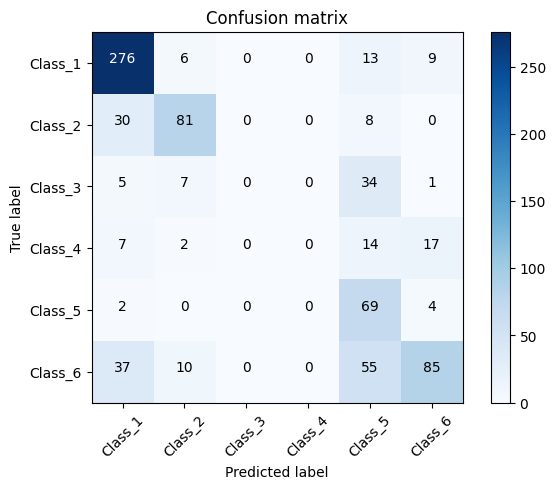

In [67]:
Classes=DataSetTrain.data.classes
plt.style.use('default')
from plotcm import plot_confusion_matrix
plot_confusion_matrix(cf_matrix, Classes)

In [ ]:
from torchsummary import summary
summary(net, (1, 224, 224))